# Learning to Learn on Fashion MNIST using 2 dense layers

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import tensorflow_datasets as tfds
import sklearn.metrics as sm
import pandas as pd
from matplotlib import pyplot as plt

### LSTM default parameters

In [ ]:
n_parameters = 6 # 3 dense layers and 3 biases
batch_size = 512
num_unroll = 20
hidden_size = 20
num_layers = 2
epochs = 50

### Retrieve and prepare data

In [ ]:
(train_data, validation_data), info = tfds.load("fashion_mnist", split=['train[:90%]', 'train[90%:]'], with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

In [ ]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

def prepare_data(batch_size=batch_size):
  (train_data, validation_data), info = tfds.load("fashion_mnist", split=['train[:90%]', 'train[90%:]'], with_info = True, data_dir='./data/', download=True)
  test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)
  
  train_data = train_data.map(format_image)
  validation_data = validation_data.map(format_image)
  test_data = test_data.map(format_image)

  train = train_data.shuffle(buffer_size=1024).batch(batch_size)
  test_x, test_y = tuple(zip(*test_data))

  test_x = np.array(test_x)
  test_y = np.array(test_y)

  valid_x, valid_y = tuple(zip(*validation_data))

  valid_x = np.array(valid_x)
  valid_y = np.array(valid_y)
  return train, test_x, test_y, valid_x, valid_y



In [ ]:
train, test_x, test_y, valid_x, valid_y = prepare_data()

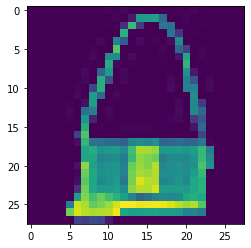

In [ ]:
plt.imshow(valid_x[3].reshape(28,28))
plt.show()

In [ ]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
# Loss and accuracy methods
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
test_val_accuracy = val_accuracy = sm.accuracy_score


### Define custom layers to allow gradient flowing

In [ ]:
class CustomDense(tf.keras.layers.Layer):
    
    def __init__(self, units=32, activation=None):
        '''Initializes the instance attributes'''
        super(CustomDense, self).__init__()
        self.units = units
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        # initialize the weights
        w_init = tf.initializers.GlorotUniform()
        self.w = tf.Variable(name="kernel",
            initial_value=w_init(shape=(input_shape[-1], self.units),
                                 dtype='float32'),
            trainable=True)

        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
            initial_value=b_init(shape=(self.units,), dtype='float32'),
            trainable=True)

    def call(self, inputs, weights, bias):
        '''Defines the computation from inputs to outputs'''

        return self.activation(tf.matmul(inputs, weights) + bias)

### Define Optimizee

In [ ]:
class MnistOptimizee(Model):
    def __init__(self, hidden_size=20, activation='tanh'):
        super(MnistOptimizee, self).__init__()
        # Now we initalize the needed layers - order does not matter.
        # -----------------------------------------------------------
        # Flatten Layer
        self.flatten = tf.keras.layers.Flatten()
        # First Dense Layer
        self.dense1 = CustomDense(hidden_size, activation=activation)
        # Second Dense Layer
        self.dense2 = CustomDense(hidden_size, activation=activation)

        # Output Layer
        self.dense3 = CustomDense(10, activation='softmax')
                        
        # keep track of training losses
        self.training_losses, self.validation_losses = [], []
        self.step_training_losses, self.step_validation_losses = [], []
        self.tensor_trainable_weights = self.trainable_weights
    
    def call(self, inputs, tensor_trainable_weights):
        x = self.flatten(inputs)        
        x = self.dense1(x, tensor_trainable_weights[0], tensor_trainable_weights[1])
        x = self.dense2(x, tensor_trainable_weights[2], tensor_trainable_weights[3])
        classifier = self.dense3(x, tensor_trainable_weights[4], tensor_trainable_weights[5])
        return classifier


### Define methods to train LSTM Optimizer and Optimizee

In [ ]:
# Train Optimizer

def train_optimizer(train_data, epochs=100, steps_limit=None):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data, for_optimizer=True, steps_limit=steps_limit)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))
    
def get_validation_data():
    """
    Helper method to calculate validation loss and validation accuracy
    """
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)

    # Take the max value after prediction for accuracy metric
    validation_predictions = np.argmax(validation_predictions, axis=1) 
    validation_accuracy = val_accuracy(y_true=valid_y, y_pred=validation_predictions)

    return validation_loss, validation_accuracy


def train_data_for_one_epoch(train_data, for_optimizer=False, steps_limit=100): 
    pbar = tqdm(total=len(list(enumerate(train_data))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    avg_validation_loss = []
    avg_validation_accuracy = []
    avg_loss = []

    for step, (x_batch_train, y_batch_train) in enumerate(train):
        if for_optimizer and steps_limit:
          if step == steps_limit:
            break
          loss = apply_optimizer_gradient(x_batch_train, y_batch_train)
        else:
          loss = apply_gradient(x_batch_train, y_batch_train)
        model.step_training_losses.append(loss)
        avg_loss.append(loss)

        validation_loss, validation_accuracy = get_validation_data()

        # save per step losses
        model.step_validation_losses.append(validation_loss)

        # store validation data
        avg_validation_loss.append(validation_loss)
        avg_validation_accuracy.append(validation_accuracy) 

        pbar.set_description("Training loss for step %s: %.4f val_loss %.4f val_acc %.3f" % (
            int(step), float(loss), float(validation_loss), float(validation_accuracy)
        ))
        pbar.update()

    avg_loss = np.mean(avg_loss)
    avg_validation_loss = np.mean(avg_validation_loss)
    avg_validation_accuracy = np.mean(avg_validation_accuracy)
    return avg_loss, avg_validation_loss, avg_validation_accuracy

def apply_optimizer_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    losses = []
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)

        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch(model.tensor_trainable_weights)

                predictions = model(x_batch_train, model.tensor_trainable_weights)  
                loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
              
                losses.append(loss_value)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                              for i in range(len(model.tensor_trainable_weights))]

        
        losses = tf.reduce_sum(losses)
        
        # calculate the loss against all losses of the optimizee
        lstm_gradients = tape_master.gradient(losses, LSTM_optimizer.trainable_weights)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 0.3)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    # calculate average loss
    losses /= LSTM_optimizer.num_unroll
    return losses

In [ ]:
# Training the model
def initialize_model(hidden_size=20):
    model.dense1.build((batch_size, 784)) # input data after flatten (28*28)
    model.dense2.build((batch_size, hidden_size))
    model.dense3.build((batch_size, hidden_size))

    model.tensor_trainable_weights = model.trainable_weights

def train_model(train_data, epochs=100):
    for epoch in range(epochs):
        loss, val_loss, val_acc = train_data_for_one_epoch(train_data)
        model.training_losses.append(loss)
        model.validation_losses.append(val_loss)
        cur_val_loss, cur_val_acc = get_validation_data()
        print("\n Epoch: %s => loss: %.4f ,avg_val_loss: %.4f avg_val_acc: %.4f, current_val_Acc %.4f \n" % (epoch, loss, val_loss, val_acc, cur_val_acc))

def apply_gradient(x_batch_train, y_batch_train):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0

    with tf.GradientTape() as tape:
        tape.watch(model.tensor_trainable_weights)

        predictions = model(x_batch_train, model.tensor_trainable_weights)  
        loss_value = loss_object(y_true=y_batch_train, y_pred=predictions)

        gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      
        loss = loss_value
        # Retrieve new results from optimizer
        lstm_optimizer_results = LSTM_optimizer(gradients) 
        # update trainable weights based on the optimer change for that step
        model.tensor_trainable_weights = [model.tensor_trainable_weights[i] + lstm_optimizer_results[i]
                                          for i in range(len(model.tensor_trainable_weights))]    
        
    return loss

### Define LSTM Optimizer

In [ ]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, n_parameters, batch_size, num_unroll, preprocessing_value=10,**kwargs):
        super().__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(1, activation='linear')
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.batches = [hidden_size*784, hidden_size, hidden_size*hidden_size, hidden_size, hidden_size * 10, 10]
        self.lstm_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size, kernel_regularizer=tf.keras.regularizers.l2(l2=0.00)) for i in range(num_layers)])
        self.state_list = []
        self.num_unroll = num_unroll
        self.preprocessing_value = preprocessing_value 
        
    def refresh_state(self): 
        self.state_list = [self.lstm_cells.get_initial_state(batch_size = self.batches[i], dtype = 'float') for i in range(n_parameters)]
    
    def call(self, gradients):
        parameter_updates = []
        for i in range(len(gradients)):
            gradient = gradients[i]  # The gradient of the i-th parameter
            state = self.state_list[i]

            try:
                gradient.shape[1] # check if the tensor is 2D as this is what the cell() accepts
            except:
                gradient = tf.reshape(gradient, [model.variables[i].shape[0], 1]) # make tensor 2D which is compatible with cell call function 
            
            flattened_grad = tf.reshape(gradient,[-1, ]) # flatten out the gradient to make it compatible with the cell
            # Preprocessing
            preprocessed_inputs = np.zeros(shape=(flattened_grad.shape[0], 2))

            condition = tf.greater_equal(flattened_grad, np.abs(flattened_grad) >= np.exp(-self.preprocessing_value))
            case_true1 = np.log(np.abs(flattened_grad) + 1e-8 ) / self.preprocessing_value # 1e-8 to help calculating gradient and stop the vanishing gradient issue
            case_false1 = -1
            preprocessed_inputs[:, 0] = tf.where(condition, case_true1, case_false1)

            case_true2 = np.sign(flattened_grad)
            case_false2 = np.exp(self.preprocessing_value) * flattened_grad
            preprocessed_inputs[:, 1] = tf.where(condition, case_true2, case_false2)

            cell_output, state = self.lstm_cells(preprocessed_inputs, state)
            self.state_list[i] = state # update the state
            # cell_output = self.batch_norm(cell_output)
            parameter_update = self.dense(cell_output) # transform the hidden layer output to a coordinate wise update 

            parameter_update = tf.reshape(parameter_update, [gradient.shape[0], gradient.shape[1]]) # reshape the update back to the dimension of the gradients
            parameter_update = parameter_update * 0.05 # rescale as paper mentions 
            parameter_updates.append(parameter_update)
        
        parameter_updates[1] = tf.squeeze(parameter_updates[1]) # biases
        parameter_updates[3] = tf.squeeze(parameter_updates[3]) # biases
        parameter_updates[5] = tf.squeeze(parameter_updates[5]) # biases

        return parameter_updates

### Train LSTM optimizer and optimizee network

In [ ]:
LSTM_optimizer = LSTMOptimizer(hidden_size=hidden_size, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model = MnistOptimizee(hidden_size=20)
initialize_model()

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 99: 0.4762 val_loss 0.7413 val_acc 0.775:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 0.4576 ,avg_val_loss: 0.7149 avg_val_acc: 0.7836, current_val_Acc 0.7752 



In [ ]:
# Initlize the model and train it with trained LSTM optimizer
model = MnistOptimizee(hidden_size=20)
initialize_model()

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.6760 val_loss 0.6472 val_acc 0.776:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.9843 ,avg_val_loss: 0.9609 avg_val_acc: 0.6633, current_val_Acc 0.7757 



### Define Model and methods for handcrafted optimizers


In [ ]:
class NormalMnistModel(tf.keras.Model):

    def __init__(self, hidden_size=20):
        super(NormalMnistModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu)

        self.dense2 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    


In [ ]:
def train_data_for_one_epoch_hand_crafted(model, optimizer, steps=None, steps_limit=None):
  # store per step
  step_train_losses, step_valid_losses = [], []

  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      if steps_limit:
        if steps == steps_limit:
        # if we reach defined number of steps break
          break
        else:
          steps += 1

      logits, loss_value = apply_gradient_hand_crafted_models(model, optimizer, x_batch_train, y_batch_train)
      
      step_train_losses.append(loss_value)
      valid_losses, validation_accuracy = perform_validation(model)
      step_valid_losses.append(valid_losses)

      pbar.set_description("Training loss for step %s: %.4f, validation loss: %.4f, validation accuracy: %.4f" % (int(step), float(loss_value), float(valid_losses), float(validation_accuracy)))
      pbar.update()

  return step_train_losses, step_valid_losses, steps

In [ ]:
def perform_validation(model):
  val_logits = model(valid_x)
  val_loss = loss_object(y_true=valid_y, y_pred=val_logits)
  
  val_logits = np.argmax(val_logits, axis=1) 
  current_val_accuracy = val_accuracy(np.array(valid_y), val_logits)
  return val_loss, current_val_accuracy

In [ ]:
def apply_gradient_hand_crafted_models(model, optimizer, train_X, train_y):
    with tf.GradientTape() as tape:
      predictions = model(train_X)
      current_loss = loss_object(train_y, predictions)

    gradients = tape.gradient(current_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return predictions, current_loss

In [ ]:
def train_hand_crafted_models(model, optimizer, epochs=1, steps_limit=None):
  train_losses, valid_losses = [], []
  steps_train_losses, steps_valid_losses = [], []
  validation_accuracy_data = []
  steps = None
  for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    current_step_train_losses, current_step_valid_losses, steps = train_data_for_one_epoch_hand_crafted(model, optimizer, steps, steps_limit)
    train_losses.append(np.mean(current_step_train_losses))
    valid_losses.append(np.mean(current_step_valid_losses)) 
    steps_train_losses += current_step_train_losses
    steps_valid_losses += current_step_valid_losses

    _ , validation_accuracy = perform_validation(model)
    validation_accuracy_data.append(validation_accuracy)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Validation Accuracy %.4f' % (epoch, float(np.mean(current_step_train_losses)), float(np.mean(current_step_valid_losses)), float(validation_accuracy)))
    
  history_data = {
      "loss": np.array(train_losses),
      "valid_loss": np.array(valid_losses),
      "steps_train_losses": np.array(steps_train_losses),
      "steps_valid_losses": np.array(steps_valid_losses),
      "val_accuracy": np.array(validation_accuracy_data)
  }
  return history_data

## Train and validate performance of handcrafted optimizers

In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.6166, validation loss: 0.6625, validation accuracy: 0.7772:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.0576  Validation Loss: 1.0394, Validation Accuracy 0.7772


In [ ]:
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.6437, validation loss: 0.7124, validation accuracy: 0.7570: 100%|██████████| 106/106 


 Epoch 0: Train loss: 1.0318  Validation Loss: 1.0169, Validation Accuracy 0.7570


In [ ]:
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)

Start of epoch 0


Training loss for step 105: 1.4381, validation loss: 1.4607, validation accuracy: 0.6002: 100%|██████████| 106/106 


 Epoch 0: Train loss: 1.8485  Validation Loss: 1.8372, Validation Accuracy 0.6002


In [ ]:
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 2.1089, validation loss: 2.1074, validation accuracy: 0.2765:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 2.2183  Validation Loss: 2.2098, Validation Accuracy 0.2765


## Plot Results for 20 hidden units

Text(0.5, 1.0, 'LSTM O')

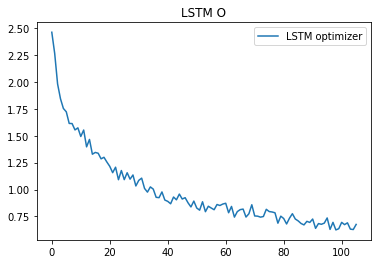

In [ ]:
plt.plot(model.step_training_losses, label='LSTM optimizer')
plt.legend()
plt.title("LSTM O")

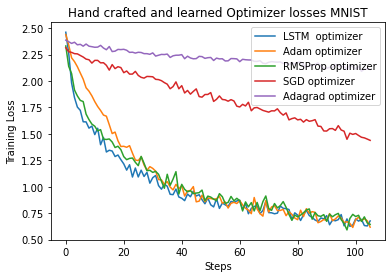

In [ ]:
def plot_steps_train_results():
  plt.plot(np.array(model.step_training_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_train_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_train_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_train_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_train_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Training Loss') 
  plt.title('Hand crafted and learned Optimizer losses MNIST')
  # show a legend on the plot
  plt.legend(loc=1)

def plot_steps_valid_results():
  plt.plot(np.array(model.step_validation_losses), label='LSTM  optimizer')
  plt.plot(adam_history['steps_valid_losses'], label='Adam optimizer')
  plt.plot(rmsprop_history['steps_valid_losses'], label='RMSProp optimizer')
  plt.plot(sgd_history['steps_valid_losses'], label='SGD optimizer')
  plt.plot(adagrad_history['steps_valid_losses'], label='Adagrad optimizer')
  plt.xlabel('Steps')
  plt.ylabel('Validation Loss') 
  plt.title('Hand crafted and learned Optimizer losses MNIST')
  # show a legend on the plot
  plt.legend(loc=1)

plot_steps_train_results()

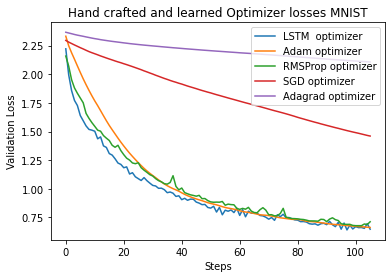

In [ ]:
plot_steps_valid_results()

## Accuracy for model with 2 dense layers


In [ ]:
def print_accuracy_report(optimizer_name, test_y, preds):
    print(f"***** {optimizer_name} Accuracy metrics******")
    print(sm.classification_report(test_y, preds, target_names=class_names))
    print()

In [ ]:
def print_accuracy_reports():
  print_accuracy_report("LSTM_optimizer", test_y, np.argmax(lstm_optimizer_preds, axis=1))
  print_accuracy_report("Adagrad", test_y, np.argmax(adagrad_preds, axis=1))
  print_accuracy_report("RMSProp", test_y, np.argmax(rms_preds, axis=1))
  print_accuracy_report("ADAM", test_y, np.argmax(adam_preds, axis=1))
  print_accuracy_report("SGD", test_y, np.argmax(sgd_preds, axis=1))

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.79      0.74      0.76      1000
 Trouser/pants       0.99      0.78      0.87      1000
Pullover shirt       0.63      0.71      0.67      1000
         Dress       0.65      0.89      0.75      1000
          Coat       0.66      0.61      0.63      1000
        Sandal       0.85      0.89      0.87      1000
         Shirt       0.53      0.35      0.42      1000
       Sneaker       0.87      0.89      0.88      1000
           Bag       0.79      0.97      0.87      1000
    Ankle boot       0.93      0.85      0.89      1000

      accuracy                           0.77     10000
     macro avg       0.77      0.77      0.76     10000
  weighted avg       0.77      0.77      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.51      0.48      0.50      1000
 Trouser/pants    

## Train a model the same model with no batch norm or weight decay on the LSTM optimizer

In [ ]:
# Use the pretrained optimizer and check how it adapts on the 40 hidden size problem
model = MnistOptimizee(hidden_size=20)
LSTM_optimizer = LSTMOptimizer(hidden_size=20, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
initialize_model(hidden_size=20)

In [ ]:
train_optimizer(train, epochs=1)


Training loss for step 99: 0.5186 val_loss 0.6680 val_acc 0.801:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 0.7246 ,avg_val_loss: 0.9331 avg_val_acc: 0.7390, current_val_Acc 0.8007 



In [ ]:
model = MnistOptimizee(hidden_size=20)
initialize_model(hidden_size=20)


In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.5603 val_loss 0.6509 val_acc 0.767:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.9468 ,avg_val_loss: 0.9253 avg_val_acc: 0.6795, current_val_Acc 0.7672 



In [ ]:
adam_model = NormalMnistModel()
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel()
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel()
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel()
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.7038, validation loss: 0.6928, validation accuracy: 0.7752:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.1582  Validation Loss: 1.1360, Validation Accuracy 0.7752
Start of epoch 0


Training loss for step 105: 0.6519, validation loss: 0.6434, validation accuracy: 0.7833:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 0.9829  Validation Loss: 0.9626, Validation Accuracy 0.7833
Start of epoch 0


Training loss for step 105: 1.7619, validation loss: 1.6884, validation accuracy: 0.4740:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.9932  Validation Loss: 1.9849, Validation Accuracy 0.4740
Start of epoch 0


Training loss for step 105: 2.0863, validation loss: 2.0581, validation accuracy: 0.2977:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 2.2008  Validation Loss: 2.1925, Validation Accuracy 0.2977


## Plot results for 2 dense layers no batch norm or weight decay



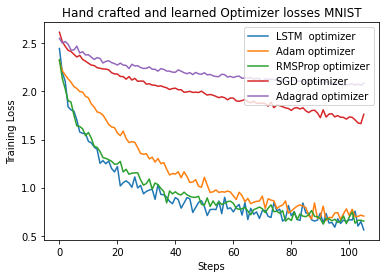

In [ ]:
plot_steps_train_results()

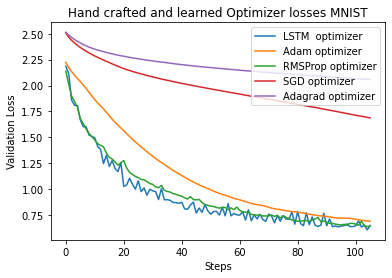

In [ ]:
plot_steps_valid_results()

## Plot Results 40 hidden layers 

In [ ]:
adam_model = NormalMnistModel(hidden_size=40)
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel(hidden_size=40)
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel(hidden_size=40)
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel(hidden_size=40)
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.4843, validation loss: 0.5424, validation accuracy: 0.8162:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 0.9050  Validation Loss: 0.8857, Validation Accuracy 0.8162
Start of epoch 0


Training loss for step 105: 0.5653, validation loss: 0.6107, validation accuracy: 0.7807: 100%|██████████| 106/106 


 Epoch 0: Train loss: 0.8697  Validation Loss: 0.8499, Validation Accuracy 0.7807
Start of epoch 0


Training loss for step 105: 1.4678, validation loss: 1.5247, validation accuracy: 0.5845: 100%|██████████| 106/106 



 Epoch 0: Train loss: 1.8959  Validation Loss: 1.8906, Validation Accuracy 0.5845
Start of epoch 0


Training loss for step 105: 2.1613, validation loss: 2.1424, validation accuracy: 0.2088: 100%|██████████| 106/106 


 Epoch 0: Train loss: 2.2336  Validation Loss: 2.2298, Validation Accuracy 0.2088


In [ ]:
# Use the pretrained optimizer and check how it adapts on the 40 hidden size problem
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 99: 0.5412 val_loss 0.6959 val_acc 0.783:  94%|█████████▍| 100/106 


 Epoch: 0 => loss: 1.0477 ,avg_val_loss: 1.2457 avg_val_acc: 0.6819, current_val_Acc 0.7833 



In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.6665 val_loss 0.6252 val_acc 0.770:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.9285 ,avg_val_loss: 0.9097 avg_val_acc: 0.6589, current_val_Acc 0.7697 



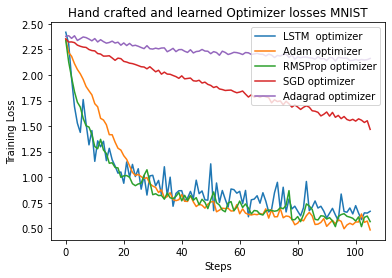

In [ ]:
plot_steps_train_results()

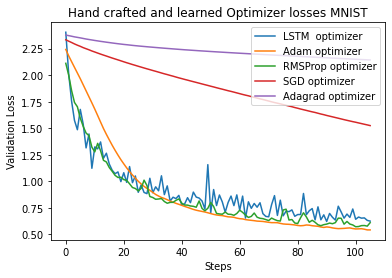

In [ ]:
plot_steps_valid_results()

### Accuracy results 

In [ ]:
adam_preds = adam_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.80      0.70      0.75      1000
 Trouser/pants       0.99      0.84      0.91      1000
Pullover shirt       0.78      0.45      0.57      1000
         Dress       0.77      0.82      0.79      1000
          Coat       0.63      0.58      0.60      1000
        Sandal       0.99      0.67      0.80      1000
         Shirt       0.39      0.69      0.50      1000
       Sneaker       0.77      0.91      0.83      1000
           Bag       0.95      0.91      0.93      1000
    Ankle boot       0.83      0.95      0.89      1000

      accuracy                           0.75     10000
     macro avg       0.79      0.75      0.76     10000
  weighted avg       0.79      0.75      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.06      0.12      0.08      1000
 Trouser/pants    

## Test training a model with 128 batch size but optimizer trained on 512 

In [ ]:
# Use the pretrained optimizer and check how it adapts on the 40 hidden size problem
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=num_unroll, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1)

Training loss for step 105: 0.8305 val_loss 0.7656 val_acc 0.752:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 1.0652 ,avg_val_loss: 1.0529 avg_val_acc: 0.6816, current_val_Acc 0.7517 



In [ ]:
train, test_x, test_y, valid_x, valid_y = prepare_data(batch_size=128)

In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 421: 0.7826 val_loss 0.7155 val_acc 0.765: 100%|█████████▉| 421/422 


 Epoch: 0 => loss: 0.8450 ,avg_val_loss: 0.8372 avg_val_acc: 0.7378, current_val_Acc 0.7655 



In [ ]:
adam_model = NormalMnistModel(hidden_size=40)
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel(hidden_size=40)
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel(hidden_size=40)
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel(hidden_size=40)
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 421: 0.5389, validation loss: 0.4618, validation accuracy: 0.8373: 100%|█████████▉| 421/422 


 Epoch 0: Train loss: 0.6353  Validation Loss: 0.6280, Validation Accuracy 0.8373
Start of epoch 0


Training loss for step 421: 0.4617, validation loss: 0.4682, validation accuracy: 0.8353: 100%|█████████▉| 421/422 


 Epoch 0: Train loss: 0.6415  Validation Loss: 0.6287, Validation Accuracy 0.8353
Start of epoch 0


Training loss for step 421: 0.8314, validation loss: 0.8155, validation accuracy: 0.7230: 100%|██████████| 422/422 


 Epoch 0: Train loss: 1.3319  Validation Loss: 1.3248, Validation Accuracy 0.7230
Start of epoch 0


Training loss for step 421: 1.6580, validation loss: 1.6261, validation accuracy: 0.5213: 100%|█████████▉| 421/422 


 Epoch 0: Train loss: 1.9474  Validation Loss: 1.9506, Validation Accuracy 0.5213


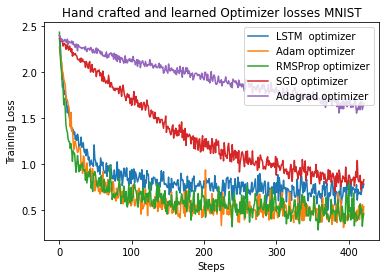

In [ ]:
plot_steps_train_results()

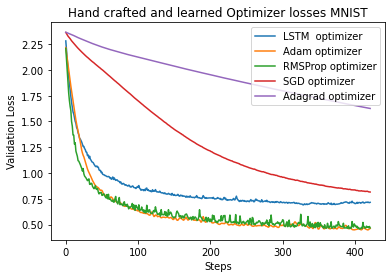

In [ ]:
plot_steps_valid_results()

### Accuracy when using an LSTM optimizer trained with 512 batch size but train a model using 128 batch size

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.80      0.70      0.75      1000
 Trouser/pants       0.99      0.84      0.91      1000
Pullover shirt       0.78      0.45      0.57      1000
         Dress       0.77      0.82      0.79      1000
          Coat       0.63      0.58      0.60      1000
        Sandal       0.99      0.67      0.80      1000
         Shirt       0.39      0.69      0.50      1000
       Sneaker       0.77      0.91      0.83      1000
           Bag       0.95      0.91      0.93      1000
    Ankle boot       0.83      0.95      0.89      1000

      accuracy                           0.75     10000
     macro avg       0.79      0.75      0.76     10000
  weighted avg       0.79      0.75      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.06      0.12      0.08      1000
 Trouser/pants    

## Train optimizer with more unrolling steps (30)



In [ ]:
train, test_x, test_y, valid_x, valid_y = prepare_data(batch_size=512)

In [ ]:
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=30, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1, steps_limit=105)

Training loss for step 104: 0.5032 val_loss 0.8207 val_acc 0.763:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.5822 ,avg_val_loss: 0.9871 avg_val_acc: 0.7355, current_val_Acc 0.7628 



In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.7642 val_loss 0.6038 val_acc 0.765: 100%|██████████| 106/106 


 Epoch: 0 => loss: 0.9099 ,avg_val_loss: 0.8889 avg_val_acc: 0.6620, current_val_Acc 0.7647 



In [ ]:
adam_model = NormalMnistModel(hidden_size=40)
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel(hidden_size=40)
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel(hidden_size=40)
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel(hidden_size=40)
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.5129, validation loss: 0.5520, validation accuracy: 0.8187:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 0.9636  Validation Loss: 0.9408, Validation Accuracy 0.8187
Start of epoch 0


Training loss for step 105: 0.5556, validation loss: 0.5864, validation accuracy: 0.7930: 100%|██████████| 106/106 


 Epoch 0: Train loss: 0.8973  Validation Loss: 0.8741, Validation Accuracy 0.7930
Start of epoch 0


Training loss for step 105: 1.7485, validation loss: 1.7868, validation accuracy: 0.4113:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 2.0421  Validation Loss: 2.0373, Validation Accuracy 0.4113
Start of epoch 0


Training loss for step 105: 2.0566, validation loss: 2.0579, validation accuracy: 0.3635:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 2.1573  Validation Loss: 2.1608, Validation Accuracy 0.3635


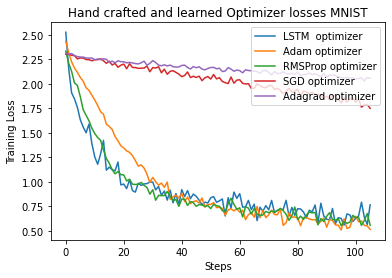

In [ ]:
plot_steps_train_results()

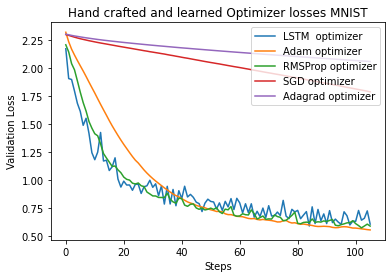

In [ ]:
plot_steps_valid_results()

### Accuracy results

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.80      0.70      0.75      1000
 Trouser/pants       0.99      0.84      0.91      1000
Pullover shirt       0.78      0.45      0.57      1000
         Dress       0.77      0.82      0.79      1000
          Coat       0.63      0.58      0.60      1000
        Sandal       0.99      0.67      0.80      1000
         Shirt       0.39      0.69      0.50      1000
       Sneaker       0.77      0.91      0.83      1000
           Bag       0.95      0.91      0.93      1000
    Ankle boot       0.83      0.95      0.89      1000

      accuracy                           0.75     10000
     macro avg       0.79      0.75      0.76     10000
  weighted avg       0.79      0.75      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.06      0.12      0.08      1000
 Trouser/pants    

## Train optimizer with less unrolling steps (10)



In [ ]:
model = MnistOptimizee(hidden_size=40)
LSTM_optimizer = LSTMOptimizer(hidden_size=40, num_layers=num_layers, n_parameters=n_parameters, batch_size=batch_size, num_unroll=10, preprocessing_value=10)
initialize_model(hidden_size=40)

In [ ]:
train_optimizer(train, epochs=1, steps_limit=105)

Training loss for step 104: 0.2937 val_loss 0.5135 val_acc 0.838:  99%|█████████▉| 105/106 


 Epoch: 0 => loss: 0.5240 ,avg_val_loss: 0.6802 avg_val_acc: 0.7734, current_val_Acc 0.8380 



In [ ]:
model = MnistOptimizee(hidden_size=40)
initialize_model(hidden_size=40)

In [ ]:
train_model(train, epochs=1)

Training loss for step 105: 0.6324 val_loss 0.5216 val_acc 0.807: 100%|██████████| 106/106 


 Epoch: 0 => loss: 0.8508 ,avg_val_loss: 0.8279 avg_val_acc: 0.7100, current_val_Acc 0.8070 



In [ ]:
adam_model = NormalMnistModel(hidden_size=40)
adam_history = train_hand_crafted_models(adam_model, tf.keras.optimizers.Adam(), epochs=1)
rmsprop_model = NormalMnistModel(hidden_size=40)
rmsprop_history = train_hand_crafted_models(rmsprop_model, tf.keras.optimizers.RMSprop(), epochs=1)
sgd_model = NormalMnistModel(hidden_size=40)
sgd_history = train_hand_crafted_models(sgd_model, tf.keras.optimizers.SGD(), epochs=1)
adagrad_model = NormalMnistModel(hidden_size=40)
adagrad_history = train_hand_crafted_models(adagrad_model, tf.keras.optimizers.Adagrad(), epochs=1)

Start of epoch 0


Training loss for step 105: 0.5327, validation loss: 0.5593, validation accuracy: 0.8108:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 0.9570  Validation Loss: 0.9316, Validation Accuracy 0.8108
Start of epoch 0


Training loss for step 105: 0.5763, validation loss: 0.5864, validation accuracy: 0.8107: 100%|██████████| 106/106 


 Epoch 0: Train loss: 0.8898  Validation Loss: 0.8663, Validation Accuracy 0.8107
Start of epoch 0


Training loss for step 105: 1.6828, validation loss: 1.6337, validation accuracy: 0.5503:  99%|█████████▉| 105/106 


 Epoch 0: Train loss: 1.9881  Validation Loss: 1.9829, Validation Accuracy 0.5503
Start of epoch 0


Training loss for step 105: 2.0754, validation loss: 2.0731, validation accuracy: 0.2865: 100%|██████████| 106/106 



 Epoch 0: Train loss: 2.1850  Validation Loss: 2.1828, Validation Accuracy 0.2865


### Plot results of trained optimizer with 10 steps

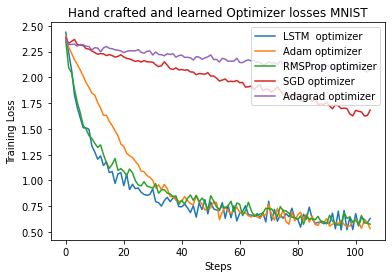

In [ ]:
plot_steps_train_results()

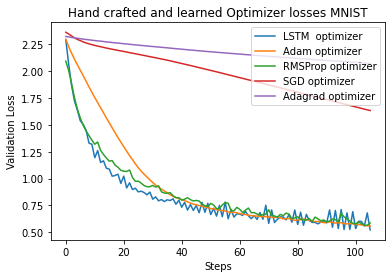

In [ ]:
plot_steps_valid_results()

### Accuracy results

In [ ]:
print_accuracy_reports()

***** LSTM_optimizer Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.80      0.70      0.75      1000
 Trouser/pants       0.99      0.84      0.91      1000
Pullover shirt       0.78      0.45      0.57      1000
         Dress       0.77      0.82      0.79      1000
          Coat       0.63      0.58      0.60      1000
        Sandal       0.99      0.67      0.80      1000
         Shirt       0.39      0.69      0.50      1000
       Sneaker       0.77      0.91      0.83      1000
           Bag       0.95      0.91      0.93      1000
    Ankle boot       0.83      0.95      0.89      1000

      accuracy                           0.75     10000
     macro avg       0.79      0.75      0.76     10000
  weighted avg       0.79      0.75      0.76     10000


***** Adagrad Accuracy metrics******
                precision    recall  f1-score   support

   T-shirt/top       0.06      0.12      0.08      1000
 Trouser/pants    